## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [38]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_train)

60000

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([256, 1, 28, 28])
torch.Size([256])
256


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 4),
            nn.ReLU(),
            nn.Linear(input_shape // 4, input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
              ReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 10]             990
Total params: 405,044
Trainable params: 405,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


Your experiments come here:

In [9]:
def fit(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_val_loss = []
        ep_val_accuracy = []


        model.train(True) 
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model(X_batch)
            y_pred = torch.argmax(preds, axis=1)
            ep_train_accuracy.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = torch.argmax(preds, axis=1)
                ep_val_accuracy.append(torch.sum(y_pred==y_batch).item() / len(y_batch))

        # print the results for this epoch:

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\t  training accuracy: {train_accuracy[-1]:.3f}")
        print(f"\t  validation loss: {val_loss[-1]:.6f}")
        print(f"\t  validation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, train_accuracy, val_accuracy

In [ ]:
model = TinyNeuralNetwork().to(device)

n_epochs = 20
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

# Your experiments, training and validation loops here

In [ ]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs)

	  training loss: 0.650119
	  training accuracy: 0.766
	  validation loss: 0.496746
	  validation accuracy: 0.822
	  training loss: 0.414242
	  training accuracy: 0.852
	  validation loss: 0.408861
	  validation accuracy: 0.852
	  training loss: 0.364123
	  training accuracy: 0.867
	  validation loss: 0.388179
	  validation accuracy: 0.859
	  training loss: 0.329829
	  training accuracy: 0.878
	  validation loss: 0.377412
	  validation accuracy: 0.865
	  training loss: 0.308636
	  training accuracy: 0.887
	  validation loss: 0.361035
	  validation accuracy: 0.871
	  training loss: 0.289880
	  training accuracy: 0.892
	  validation loss: 0.358893
	  validation accuracy: 0.871
	  training loss: 0.279694
	  training accuracy: 0.896
	  validation loss: 0.356465
	  validation accuracy: 0.877
	  training loss: 0.265354
	  training accuracy: 0.901
	  validation loss: 0.326743
	  validation accuracy: 0.884
	  training loss: 0.253068
	  training accuracy: 0.906
	  validation loss: 0.325191
	  v

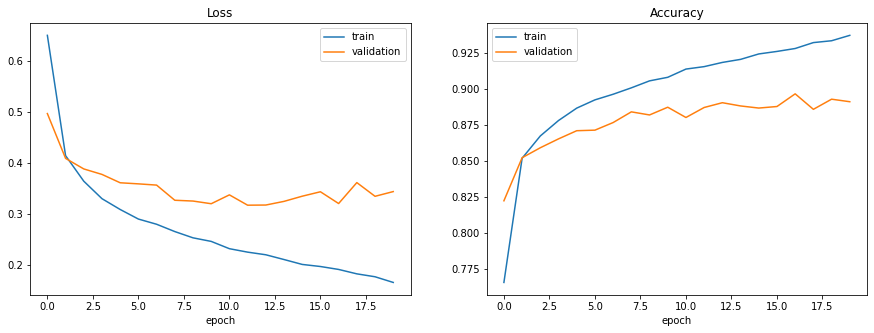

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].set_xlabel('epoch')
axes[0].legend()

axes[1].set_title('Accuracy')
axes[1].plot(train_accuracy, label='train')
axes[1].plot(val_accuracy, label='validation')
axes[1].set_xlabel('epoch')
axes[1].legend()

In [10]:
def test(model, test_loader):
    accuracy = []
    model.train(False) 
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            y_pred = torch.argmax(predictions, axis=1)
            accuracy.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
    return np.mean(accuracy)

In [ ]:
print("Test_accuracy = ", test(model, test_loader))

Test_accuracy =  0.8912109375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [11]:
indices = np.arange(20000)
train_dataset_decreased = torch.utils.data.Subset(fmnist_dataset_train, indices)
train_loader = torch.utils.data.DataLoader(train_dataset_decreased, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 4),
            nn.ReLU(),
            nn.Linear(input_shape * 4, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, input_shape // 16),
            nn.ReLU(),
            nn.Linear(input_shape // 16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
class OverfittingNeuralNetwork1(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, input_shape // 16),
            nn.ReLU(),
            nn.Linear(input_shape // 16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
class OverfittingNeuralNetwork2(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 4),
            nn.ReLU(),
            nn.Linear(input_shape // 4, input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 3136]       2,461,760
              ReLU-3                 [-1, 3136]               0
            Linear-4                 [-1, 1568]       4,918,816
              ReLU-5                 [-1, 1568]               0
            Linear-6                  [-1, 392]         615,048
              ReLU-7                  [-1, 392]               0
            Linear-8                   [-1, 98]          38,514
              ReLU-9                   [-1, 98]               0
           Linear-10                   [-1, 49]           4,851
             ReLU-11                   [-1, 49]               0
           Linear-12                   [-1, 10]             500
Total params: 8,039,489
Trainable params: 8,039,489
Non-trainable params: 0
---------------------------

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork1().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 392]         615,048
              ReLU-5                  [-1, 392]               0
            Linear-6                   [-1, 98]          38,514
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 49]           4,851
              ReLU-9                   [-1, 49]               0
           Linear-10                   [-1, 10]             500
Total params: 1,889,793
Trainable params: 1,889,793
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 7.21
Estimat

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork2().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
              ReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 10]             990
Total params: 405,044
Trainable params: 405,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
n_epochs = 50
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

In [ ]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs)

	  training loss: 1.001745
	  training accuracy: 0.610
	  validation loss: 0.721925
	  validation accuracy: 0.737
	  training loss: 0.533322
	  training accuracy: 0.800
	  validation loss: 0.545067
	  validation accuracy: 0.794
	  training loss: 0.450711
	  training accuracy: 0.834
	  validation loss: 0.473693
	  validation accuracy: 0.833
	  training loss: 0.401624
	  training accuracy: 0.855
	  validation loss: 0.445174
	  validation accuracy: 0.839
	  training loss: 0.384331
	  training accuracy: 0.857
	  validation loss: 0.460353
	  validation accuracy: 0.832
	  training loss: 0.348831
	  training accuracy: 0.870
	  validation loss: 0.417098
	  validation accuracy: 0.855
	  training loss: 0.329965
	  training accuracy: 0.878
	  validation loss: 0.513131
	  validation accuracy: 0.823
	  training loss: 0.313252
	  training accuracy: 0.883
	  validation loss: 0.396486
	  validation accuracy: 0.862
	  training loss: 0.311334
	  training accuracy: 0.885
	  validation loss: 0.437304
	  v

In [ ]:
model = OverfittingNeuralNetwork1().to(device)
n_epochs = 50
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

In [ ]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs)

	  training loss: 0.984522
	  training accuracy: 0.644
	  validation loss: 0.633412
	  validation accuracy: 0.771
	  training loss: 0.519439
	  training accuracy: 0.813
	  validation loss: 0.528011
	  validation accuracy: 0.814
	  training loss: 0.459694
	  training accuracy: 0.831
	  validation loss: 0.469494
	  validation accuracy: 0.829
	  training loss: 0.400317
	  training accuracy: 0.855
	  validation loss: 0.433708
	  validation accuracy: 0.844
	  training loss: 0.359940
	  training accuracy: 0.866
	  validation loss: 0.504125
	  validation accuracy: 0.828
	  training loss: 0.348864
	  training accuracy: 0.871
	  validation loss: 0.391658
	  validation accuracy: 0.862
	  training loss: 0.320998
	  training accuracy: 0.879
	  validation loss: 0.418674
	  validation accuracy: 0.849
	  training loss: 0.306149
	  training accuracy: 0.886
	  validation loss: 0.391181
	  validation accuracy: 0.860
	  training loss: 0.296074
	  training accuracy: 0.889
	  validation loss: 0.481265
	  v

In [ ]:
model = OverfittingNeuralNetwork2().to(device)
n_epochs = 50
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

In [ ]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs)

	  training loss: 0.945249
	  training accuracy: 0.665
	  validation loss: 0.646437
	  validation accuracy: 0.754
	  training loss: 0.536782
	  training accuracy: 0.805
	  validation loss: 0.531554
	  validation accuracy: 0.802
	  training loss: 0.454716
	  training accuracy: 0.839
	  validation loss: 0.502344
	  validation accuracy: 0.818
	  training loss: 0.424334
	  training accuracy: 0.849
	  validation loss: 0.437151
	  validation accuracy: 0.843
	  training loss: 0.387547
	  training accuracy: 0.860
	  validation loss: 0.423434
	  validation accuracy: 0.850
	  training loss: 0.360800
	  training accuracy: 0.869
	  validation loss: 0.466506
	  validation accuracy: 0.834
	  training loss: 0.343814
	  training accuracy: 0.876
	  validation loss: 0.413273
	  validation accuracy: 0.852
	  training loss: 0.321175
	  training accuracy: 0.882
	  validation loss: 0.414230
	  validation accuracy: 0.850
	  training loss: 0.310211
	  training accuracy: 0.883
	  validation loss: 0.385072
	  v

In [16]:
def plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('epoch')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].set_xlabel('epoch')
    axes[1].legend()
    plt.show()

Model with 8 layers, 405044 trainable parameters

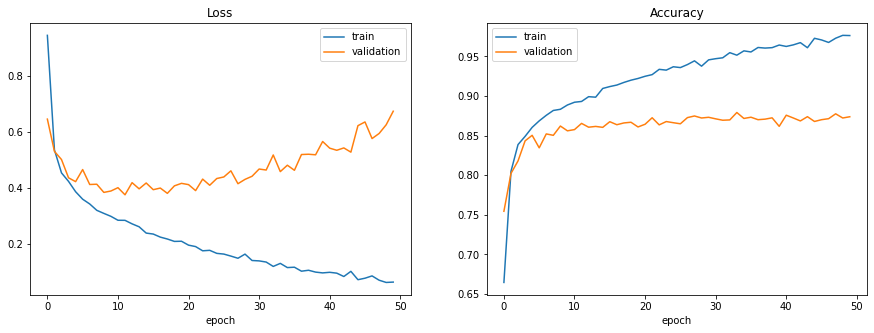

In [ ]:
plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy)

Model with 10 layers, 1889793 trainable parameters

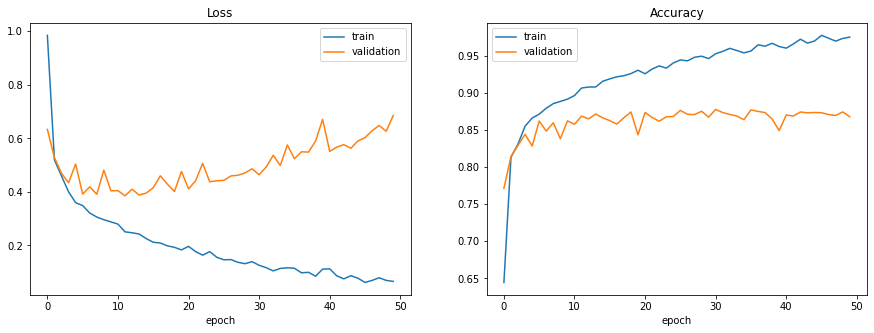

In [ ]:
plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy)

Model with 12 layers, 8039489 trainable parameters

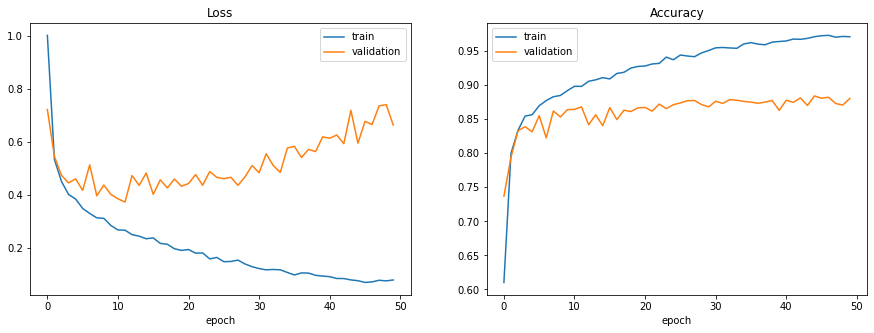

In [ ]:
plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [39]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.Dropout(p = 0.4),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape // 2),
            nn.Dropout(p = 0.4),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 8),
            nn.Dropout(p = 0.4),
            nn.ReLU(),
            nn.Linear(input_shape // 8, input_shape // 16),
            nn.Dropout(p = 0.4),
            nn.ReLU(),
            nn.Linear(input_shape // 16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [29]:
class FixedNeuralNetwork_bn(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.BatchNorm1d(input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape // 2),
            nn.BatchNorm1d(input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 8),
            nn.BatchNorm1d(input_shape // 8),
            nn.ReLU(),
            nn.Linear(input_shape // 8, input_shape // 16),
            nn.ReLU(),
            nn.Linear(input_shape // 16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [40]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
           Dropout-3                 [-1, 1568]               0
              ReLU-4                 [-1, 1568]               0
            Linear-5                  [-1, 392]         615,048
           Dropout-6                  [-1, 392]               0
              ReLU-7                  [-1, 392]               0
            Linear-8                   [-1, 98]          38,514
           Dropout-9                   [-1, 98]               0
             ReLU-10                   [-1, 98]               0
           Linear-11                   [-1, 49]           4,851
          Dropout-12                   [-1, 49]               0
             ReLU-13                   [-1, 49]               0
           Linear-14                   

In [30]:
torchsummary.summary(FixedNeuralNetwork_bn().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
              ReLU-4                 [-1, 1568]               0
            Linear-5                  [-1, 392]         615,048
       BatchNorm1d-6                  [-1, 392]             784
              ReLU-7                  [-1, 392]               0
            Linear-8                   [-1, 98]          38,514
       BatchNorm1d-9                   [-1, 98]             196
             ReLU-10                   [-1, 98]               0
           Linear-11                   [-1, 49]           4,851
             ReLU-12                   [-1, 49]               0
           Linear-13                   [-1, 10]             500
Total params: 1,893,909
Trainable param

In [41]:
model = FixedNeuralNetwork().to(device)
n_epochs = 80
#scheduler = ExponentialLR(optimizer, gamma=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

In [26]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs)

	  training loss: 1.302588
	  training accuracy: 0.509
	  validation loss: 0.710576
	  validation accuracy: 0.748
	  training loss: 0.747722
	  training accuracy: 0.728
	  validation loss: 0.539724
	  validation accuracy: 0.800
	  training loss: 0.608767
	  training accuracy: 0.784
	  validation loss: 0.544591
	  validation accuracy: 0.798
	  training loss: 0.548816
	  training accuracy: 0.806
	  validation loss: 0.481994
	  validation accuracy: 0.834
	  training loss: 0.514858
	  training accuracy: 0.822
	  validation loss: 0.469606
	  validation accuracy: 0.832
	  training loss: 0.486663
	  training accuracy: 0.834
	  validation loss: 0.441689
	  validation accuracy: 0.843
	  training loss: 0.466193
	  training accuracy: 0.839
	  validation loss: 0.451741
	  validation accuracy: 0.843
	  training loss: 0.446099
	  training accuracy: 0.849
	  validation loss: 0.415984
	  validation accuracy: 0.850
	  training loss: 0.424248
	  training accuracy: 0.855
	  validation loss: 0.428925
	  v

Model with Dropout(p=0.4), 50 epochs, reduced training dataset

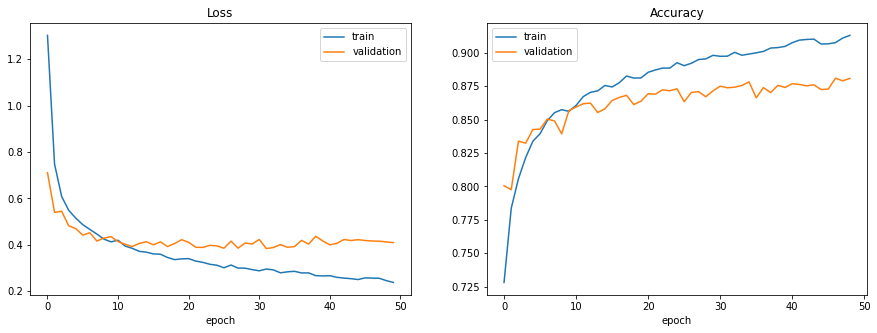

In [28]:
plot_loss_acc(train_loss, val_loss, train_accuracy[1::], val_accuracy[1::])

In [35]:
model = FixedNeuralNetwork_bn().to(device)
n_epochs = 50
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()

In [32]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs) 

	  training loss: 0.790808
	  training accuracy: 0.793
	  validation loss: 0.524839
	  validation accuracy: 0.818
	  training loss: 0.386892
	  training accuracy: 0.861
	  validation loss: 0.539309
	  validation accuracy: 0.801
	  training loss: 0.329533
	  training accuracy: 0.879
	  validation loss: 0.416850
	  validation accuracy: 0.850
	  training loss: 0.288969
	  training accuracy: 0.894
	  validation loss: 0.421104
	  validation accuracy: 0.848
	  training loss: 0.268875
	  training accuracy: 0.901
	  validation loss: 0.409635
	  validation accuracy: 0.866
	  training loss: 0.235964
	  training accuracy: 0.911
	  validation loss: 0.472074
	  validation accuracy: 0.845
	  training loss: 0.219390
	  training accuracy: 0.920
	  validation loss: 0.398977
	  validation accuracy: 0.862
	  training loss: 0.220732
	  training accuracy: 0.919
	  validation loss: 0.434331
	  validation accuracy: 0.854
	  training loss: 0.209087
	  training accuracy: 0.922
	  validation loss: 0.427597
	  v

In [ ]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs) 

Model with BatchNormalization, 50 epochs, reduced training dataset

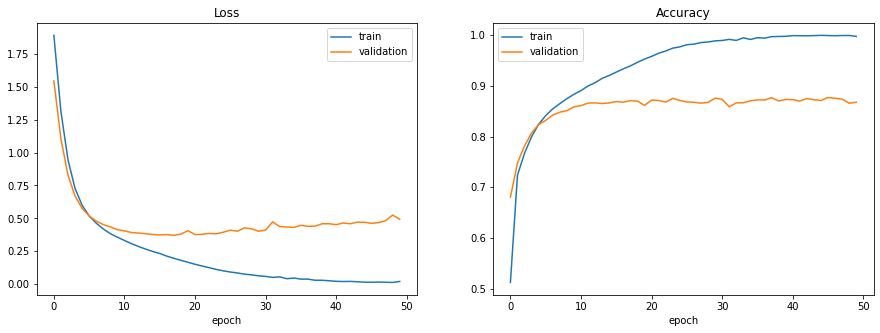

In [37]:
plot_loss_acc(train_loss, val_loss, train_accuracy, val_accuracy)

In [42]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(model, train_loader, test_loader, loss_func, opt, n_epochs)

	  training loss: 0.901288
	  training accuracy: 0.657
	  validation loss: 0.507484
	  validation accuracy: 0.802
	  training loss: 0.545084
	  training accuracy: 0.808
	  validation loss: 0.438318
	  validation accuracy: 0.838
	  training loss: 0.474792
	  training accuracy: 0.838
	  validation loss: 0.406555
	  validation accuracy: 0.853
	  training loss: 0.442019
	  training accuracy: 0.850
	  validation loss: 0.389120
	  validation accuracy: 0.860
	  training loss: 0.413352
	  training accuracy: 0.859
	  validation loss: 0.377229
	  validation accuracy: 0.866
	  training loss: 0.395040
	  training accuracy: 0.865
	  validation loss: 0.373231
	  validation accuracy: 0.866
	  training loss: 0.382202
	  training accuracy: 0.869
	  validation loss: 0.356051
	  validation accuracy: 0.873
	  training loss: 0.369284
	  training accuracy: 0.874
	  validation loss: 0.357132
	  validation accuracy: 0.875
	  training loss: 0.361592
	  training accuracy: 0.873
	  validation loss: 0.348348
	  v

Model with Dropout, 80 epochs, full training dataset

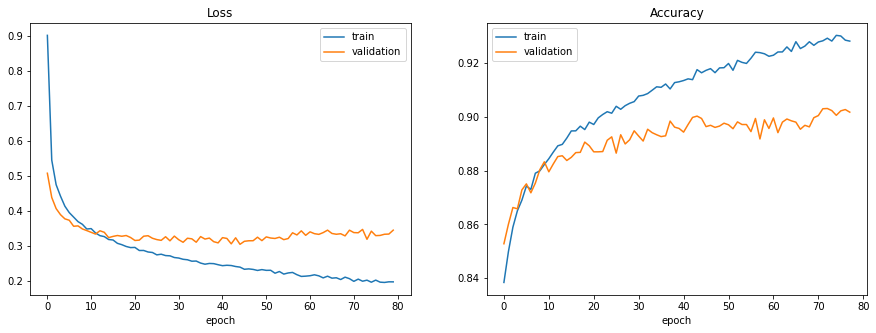

In [46]:
plot_loss_acc(train_loss, val_loss, train_accuracy[2::], val_accuracy[2::])

In [44]:
print("Test_accuracy = ", test(model, test_loader))

Test_accuracy =  0.9017578125


### Conclusions:
_Write down small report with your conclusions and your ideas._

**Task 1**. Реализовала модель, состоящую только из линейных слоев и активаций, тренировала ее 20 эпох до достижения значения метрики на тестовой выборке 0.89. По графику сравнения лосса на тренировочной и тестовой выборке видно переобучение даже для небольшой архитектуры(8 слоев, около 400000 параметров): примерно на середине обучения лосс на валидационной выборке практически перестает уменьшаться, в то время как лосс на тренировочной выборке продолжает спадать монотонно.


**Task 2**. Уменьшила втрое размер тренировочного датасета. Последовательно увеличивала сложность моделей за счет добавления линейных слоев и и активаций, каждая модель обучалась 50 эпох, затем я сравнила лосс и метрику на тренирочной и тестовой выборках. Получилось 3 модели: OverfittingNeuralNetwork2 из 8 слоев, 405044 параметров; OverfittingNeuralNetwork1 из 10 слоев, 1889793 параметра; OverfittingNeuralNetwork из 12 слоев, 8039489 параметров. Переобучение произошло в каждом эксперименте: примерно с середины обучения наблюдала рост лосса на тестовой выборке и продолжение уменьшения лосса на тренировочной; увеличение accuracy на тренировочной выборке и флуктуацию accuracy около одного значения на тестовой. При этом чем сложнее модель, тем раньше проявлялось переобучение и тем интенсивнее шел рост лосса на валидации -> чем сложнее модель, тем более она склонна к переобучению.


**Task 3**. Уже для уменьшенного тренировочного датасета и модели 2(1889793 параметра) применила техники регуляризации: Dropout и BatchNormalization, для Dropout варьировала параметр вероятности зануления нейронов - оптимальным оказалось значение p=0.4. Тренировала получившиеся модели тоже 50 эпох, по графикам видно, что техники борьбы с переобучением дали профит: лосс на валидационной выборке не начинает расти, значение accuracy на ней выше, чем в переобученных сетках и меньше отличается от accuracy на тренировочной. Оказалось, что для такой архитектуры Dropout лучше борется с переобучением, чем BatchNormalization, поэтому сетку с Dropout потом учила на полном тренировочном датасете 80 эпох(последний график) - увеличение объема датасета тоже помогает не сетке переобучаться. Явного переобучения не наблюдается, accuracy на тесте 0.9. Но рост метрики на тесте идет очень медленно, думаю, что для дальнейшего улучшения классификации картинок уже надо применять сверточные слои.

**Под тестом и валидацией в работе имею в виду одно и то же, так как задача просто отследить и побороть переобучение, а графики метрики и лосса для теста не использовались для подбора гиперпараметров моделей, кроме p в Dropout.